In [1]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.svm import SVR

## Data processing

In [2]:
## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')
data_flow_kratie = pd.read_csv('data_mrc/Discharge_Kratie.csv')
data_gdp = pd.read_csv('data_imf/thailand_gdp_imf.csv', delimiter=';')
data_rice = pd.read_csv('data_fao/rice_prod.csv')
data_rain_ck = pd.read_csv('data_mrc/Rainfall_ChiangKhan.csv')
data_flow_ck = pd.read_csv('data_mrc/Discharge_ChiangKhan.csv')
data_iea = pd.read_csv('data_iea/cambodia_renewable.csv')

# rename columns for unique identification
data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_rain_ck = data_rain_ck.rename(columns={'Value': 'rainfall_ck'})
data_flow_ck = data_flow_ck.rename(columns={'Value': 'flowrate_ck'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})
data_flow_kratie = data_flow_kratie.rename(columns={'Value': 'flowrate_kratie'})
data_gdp = data_gdp.rename(columns={'GDP (Billions of U.S. dollars)': 'gdp'})
data_rice = data_rice.rename(columns={'production (t)': 'rice'})
data_iea = data_iea.rename(columns={'generation (GWh)': 'elec'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]
data_flow_kratie = data_flow_kratie[['Timestamp (UTC+07:00)', 'flowrate_kratie']]
data_rain_ck = data_rain_ck[['Timestamp (UTC+07:00)', 'rainfall_ck']]
data_flow_ck = data_flow_ck[['Timestamp (UTC+07:00)', 'flowrate_ck']]
data_rice = data_rice[data_rice['country']=='Cambodia'][['year', 'rice']]
data_iea = data_iea[data_iea['source']=='hydro'][['year', 'elec']]

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df = pd.merge(df, data_rain_ck, on='Timestamp (UTC+07:00)', how='inner')
df = pd.merge(df, data_flow_ck, on='Timestamp (UTC+07:00)', how='inner')
df = pd.merge(df, data_flow_kratie, on='Timestamp (UTC+07:00)', how='inner')
df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%d %H:%M:%S')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})
df.set_index('date', inplace=True)

# Calculate the minimum flowrate over the past week / month (base flowrate)
df['min_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).min()
df['min_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).min()

df['min_flow_month_ck'] = df['flowrate_ck'].rolling(window=30, min_periods=1).min()

# add lag rainfall features
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)
df['rainfall_lag3'] = df['rainfall'].shift(3)
df['rainfall_lag5weeks'] = df['rainfall'].shift(35)
df['rainfall_week'] = df['rainfall'].rolling(window=7, min_periods=1).sum()
df['rainfall_5weeks'] = df['rainfall'].rolling(window=35, min_periods=1).sum()

df['rainfall_lag1_ck'] = df['rainfall_ck'].shift(1)
df['rainfall_lag2_ck'] = df['rainfall_ck'].shift(2)
df['rainfall_lag3_ck'] = df['rainfall_ck'].shift(3)
df['rainfall_lag5weeks_ck'] = df['rainfall_ck'].shift(35)
df['rainfall_week_ck'] = df['rainfall_ck'].rolling(window=7, min_periods=1).sum()
df['rainfall_5weeks_ck'] = df['rainfall_ck'].rolling(window=35, min_periods=1).sum()

# extract DateTime components
df['year'] = df.index.year
df['month'] = df.index.month
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# merge with gdp data
df = pd.merge(df, data_gdp, on='year', how='left')
df = pd.merge(df, data_rice, on='year', how='left')
df = pd.merge(df, data_iea, on='year', how='left')

# scale data
scaler_rain = StandardScaler()
df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_5weeks', 'rainfall_ck', 'rainfall_lag1_ck','rainfall_lag2_ck','rainfall_lag3_ck', 'rainfall_lag5weeks_ck' ,'rainfall_week_ck', 'rainfall_5weeks_ck']] \
    = scaler_rain.fit_transform(df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_lag5weeks' ,'rainfall_week', 'rainfall_5weeks', 'rainfall_ck', 'rainfall_lag1_ck','rainfall_lag2_ck','rainfall_lag3_ck', 'rainfall_lag5weeks_ck' ,'rainfall_week_ck', 'rainfall_5weeks_ck']])
scaler_flow = StandardScaler()
df[['flowrate', 'min_flow_week','min_flow_month']] = scaler_flow.fit_transform(df[['flowrate', 'min_flow_week','min_flow_month']])
scaler_flow_ck = StandardScaler()
df[['flowrate_ck','min_flow_month_ck']] = scaler_flow_ck.fit_transform(df[['flowrate_ck', 'min_flow_month_ck']])
scaler_flow_kratie = StandardScaler()
df[['flowrate_kratie']] = scaler_flow_kratie.fit_transform(df[['flowrate_kratie']])
scaler_gdp = StandardScaler()
df[['gdp']] = scaler_gdp.fit_transform(df[['gdp']])
scaler_rice = StandardScaler()
df[['rice']] = scaler_rice.fit_transform(df[['rice']])
scaler_elec = StandardScaler()
df[['elec']] = scaler_elec.fit_transform(df[['elec']])

In [3]:
# drop rows with missing values
df.dropna(inplace=True)
df.head()

,rainfall,flowrate,rainfall_ck,flowrate_ck,flowrate_kratie,min_flow_week,min_flow_month,min_flow_month_ck,rainfall_lag1,rainfall_lag2,...,rainfall_lag3_ck,rainfall_lag5weeks_ck,rainfall_week_ck,rainfall_5weeks_ck,year,month,week_of_year,gdp,rice,elec
35,0.326446,1.570600,2.881608,3.027730,1.471277,1.532677,-0.104346,-0.482993,1.383120,0.551179,...,0.853895,0.364932,2.892454,1.389288,2008,9,38,-2.340008,-2.634104,-1.332055
36,3.442575,1.908815,0.483043,3.101763,1.693867,1.532677,0.038560,-0.482993,0.326326,1.382901,...,0.083158,-0.308539,3.117389,1.459783,2008,9,38,-2.340008,-2.634104,-1.332055
37,2.392501,2.155112,-0.278406,2.580281,1.928172,1.532677,0.073638,-0.475934,3.442164,0.326205,...,2.861618,-0.156771,2.466977,1.448742,2008,9,38,-2.340008,-2.634104,-1.332055
38,0.299171,2.200480,1.311119,2.232842,2.122539,1.532677,0.747354,0.844627,2.392188,3.441752,...,2.880648,-0.213684,2.334184,1.584637,2008,9,38,-2.340008,-2.634104,-1.332055
39,-0.082674,1.964366,0.045209,1.862673,2.060590,1.568056,0.747354,0.999927,0.299053,2.391874,...,0.482799,-0.005003,2.103830,1.588884,2008,9,38,-2.340008,-2.634104,-1.332055


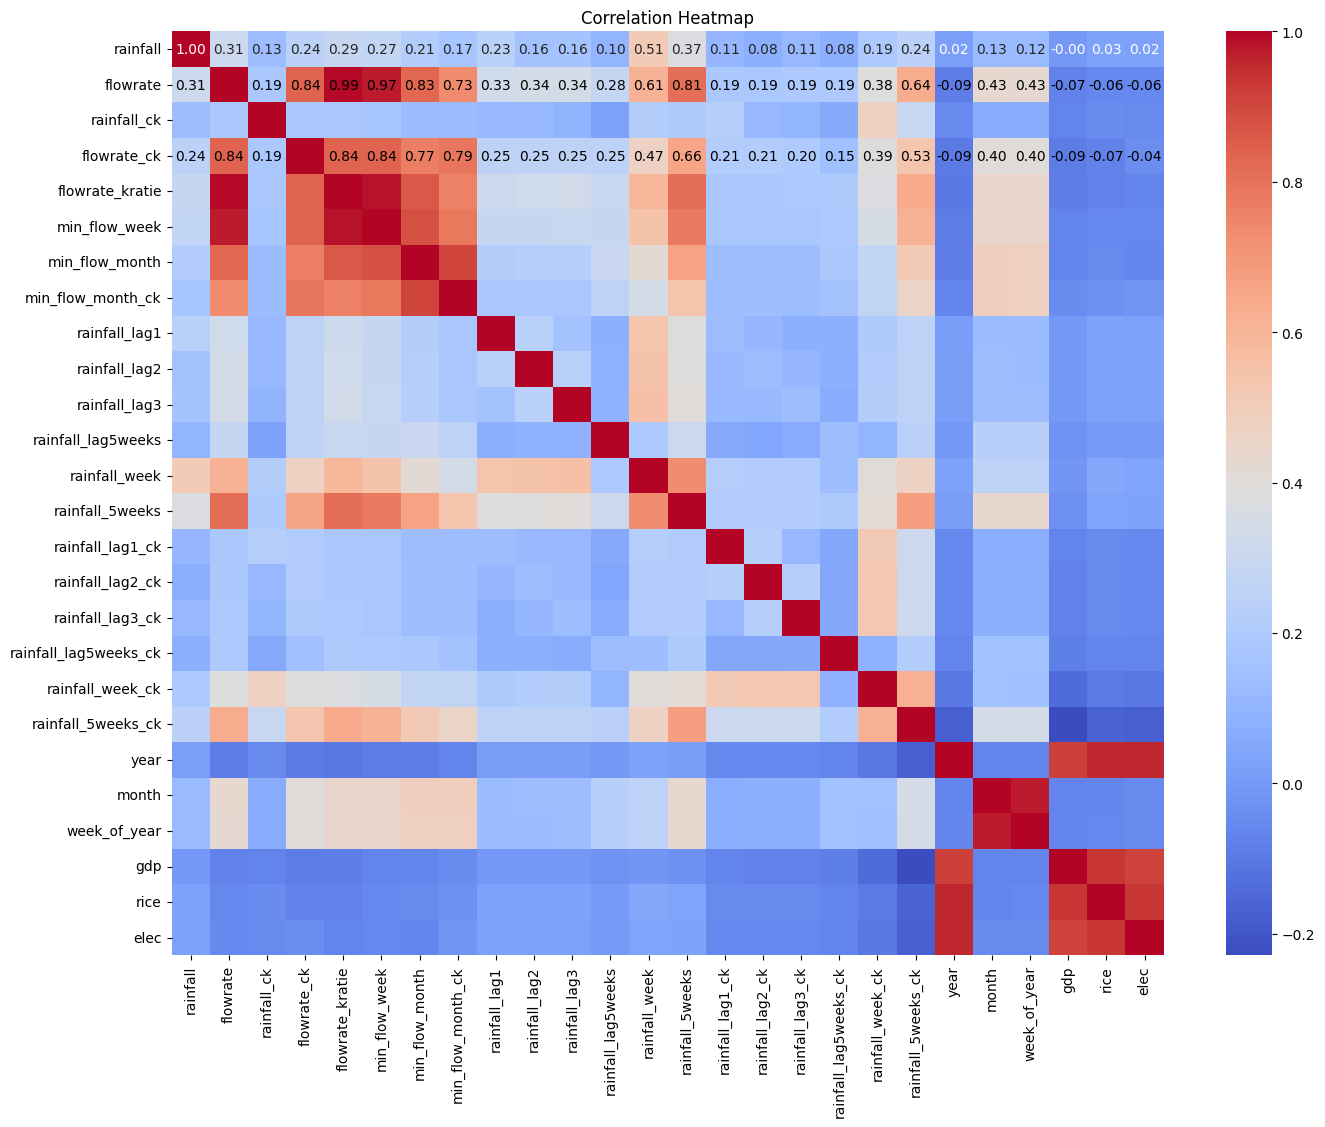

In [4]:
## heatmap ##
plt.figure(figsize=(16, 12))
corr = df.corr()

ax = sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Custom annotations for the "flowrate" row
for i in range(len(corr.columns)):
    if corr.index[i] == 'flowrate':
        for j in range(len(corr.columns)):
            if corr.columns[j] != 'flowrate':
                ax.text(j + 0.5, i + 0.5, f"{corr.iloc[i, j]:.2f}", 
                        color='black', ha='center', va='center')
for i in range(len(corr.columns)):
    if corr.index[i] == 'flowrate_ck':
        for j in range(len(corr.columns)):
            if corr.columns[j] != 'flowrate_ck':
                ax.text(j + 0.5, i + 0.5, f"{corr.iloc[i, j]:.2f}", 
                        color='black', ha='center', va='center')
                
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# Define features and target variable
X = df[['year', 'month', 'week_of_year', 'rainfall_ck', 'rainfall_lag1_ck', 'rainfall_lag2_ck', 'rainfall_lag3_ck', 'rainfall_lag5weeks_ck', 'rainfall_week_ck', 'rainfall_5weeks_ck', 'gdp', 'min_flow_month_ck', 'rice', 'elec']]
y = df['flowrate_ck']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Models

In [7]:
lasso_model = Lasso()

# Define the hyperparameter grid for Lasso
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(lasso_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    print(f"Best alpha: {best_model.alpha}")
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Lasso Regression Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Best alpha: 0.01
Best alpha: 0.001
Best alpha: 0.001
Best alpha: 0.001
Best alpha: 0.001
Lasso Regression Model
Mean Cross-Validation MSE: 0.3679 ± 0.0394
Mean Cross-Validation R²: 0.6679 ± 0.0149


In [8]:
# Define the Ridge regression model
ridge_model = Ridge()

# Create a pipeline with feature selection and Ridge regression
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(Lasso(random_state=42))),  # Placeholder, will be tuned
    ('ridge', ridge_model)
])

# Define the hyperparameter grid for both feature selection and Ridge regression
param_grid = {
    'feature_selection__estimator__alpha': [0.0001, 0.001, 0.01, 0.1],  # Lasso alpha values for feature selection
    'ridge__alpha': [0.0001, 0.001, 0.01, 0.1]  # Ridge alpha values
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    print(best_model.get_params())
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Ridge Regression Model with Lasso Feature Selection")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

{'memory': None, 'steps': [('feature_selection', SelectFromModel(estimator=Lasso(alpha=0.001, random_state=42))), ('ridge', Ridge(alpha=0.1))], 'verbose': False, 'feature_selection': SelectFromModel(estimator=Lasso(alpha=0.001, random_state=42)), 'ridge': Ridge(alpha=0.1), 'feature_selection__estimator__alpha': 0.001, 'feature_selection__estimator__copy_X': True, 'feature_selection__estimator__fit_intercept': True, 'feature_selection__estimator__max_iter': 1000, 'feature_selection__estimator__positive': False, 'feature_selection__estimator__precompute': False, 'feature_selection__estimator__random_state': 42, 'feature_selection__estimator__selection': 'cyclic', 'feature_selection__estimator__tol': 0.0001, 'feature_selection__estimator__warm_start': False, 'feature_selection__estimator': Lasso(alpha=0.001, random_state=42), 'feature_selection__importance_getter': 'auto', 'feature_selection__max_features': None, 'feature_selection__norm_order': 1, 'feature_selection__prefit': False, 'fea

In [9]:
## Bayesian Ridge Regression model
br_model = BayesianRidge()

# Create a pipeline with Lasso for feature selection and Bayesian Ridge Regression
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(Lasso(random_state=42))),  # Feature selection step
    ('bayesian_ridge', br_model)  # Bayesian Ridge Regression step
])

# Define the hyperparameter grid for Bayesian Ridge Regression
param_grid = {
    'feature_selection__estimator__alpha': [0.0001, 0.001, 0.01, 0.1],  # Lasso alpha values for feature selection
    'bayesian_ridge__max_iter': [50, 100, 150, 200, 250, 300],  # Number of iterations for the solver
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Bayesian Ridge Regression Model with Lasso Feature Selection")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Bayesian Ridge Regression Model with Lasso Feature Selection
Mean Cross-Validation MSE: 0.3676 ± 0.0394
Mean Cross-Validation R²: 0.6682 ± 0.0144


In [10]:
en_model = ElasticNet()

# Define the hyperparameter grid for ElasticNet regression
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10],  # Regularization strength
    'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 1.0]  # Mix of L1 and L2 regularization
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(en_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("ElasticNet Regression Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

ElasticNet Regression Model
Mean Cross-Validation MSE: 0.3678 ± 0.0392
Mean Cross-Validation R²: 0.6680 ± 0.0143


In [11]:
dt_model = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 5, 7, 9, 10, 11],
    'min_samples_split': [10, 15, 17, 19, 21],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'max_features': [None, 6, 7, 8, 9]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(dt_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Decision Tree Regressor Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

Decision Tree Regressor Model
Mean Cross-Validation MSE: 0.0867 ± 0.0053
Mean Cross-Validation R²: 0.9211 ± 0.0082


In [12]:
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for RandomForest regression
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6],
    'max_features': [6, 7, 8, 9]
}

# Set up nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Initialize lists to store results
outer_cv_mse_scores = []
outer_cv_r2_scores = []

# Perform nested cross-validation
for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Perform hyperparameter tuning using GridSearchCV within the training data
    grid_search = GridSearchCV(rf_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    print(best_model.get_params())
    
    # Evaluate the best model on the validation data
    y_pred = best_model.predict(X_val_fold)
    mse_score = mean_squared_error(y_val_fold, y_pred)
    r2_score_value = r2_score(y_val_fold, y_pred)
    
    # Store the results
    outer_cv_mse_scores.append(mse_score)
    outer_cv_r2_scores.append(r2_score_value)

# Calculate the mean and standard deviation of the scores
mean_mse = np.mean(outer_cv_mse_scores)
std_mse = np.std(outer_cv_mse_scores)
mean_r2 = np.mean(outer_cv_r2_scores)
std_r2 = np.std(outer_cv_r2_scores)

# Print cross-validation results
print("Random Forest Regression Model")
print(f"Mean Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"Mean Cross-Validation R²: {mean_r2:.4f} ± {std_r2:.4f}")

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_le

## Best model evaluated on test set


Random Forest Regression Model (Test Set Evaluation)
Test MSE: 0.6099
Test R-squared: -1.3553

Feature Importances:
                  Feature  Importance
11      min_flow_month_ck    0.401164
2            week_of_year    0.310853
1                   month    0.140240
9      rainfall_5weeks_ck    0.050401
8        rainfall_week_ck    0.026418
0                    year    0.011858
10                    gdp    0.011323
12                   rice    0.011305
13                   elec    0.011091
4        rainfall_lag1_ck    0.006095
5        rainfall_lag2_ck    0.005547
3             rainfall_ck    0.004757
6        rainfall_lag3_ck    0.004580
7   rainfall_lag5weeks_ck    0.004369


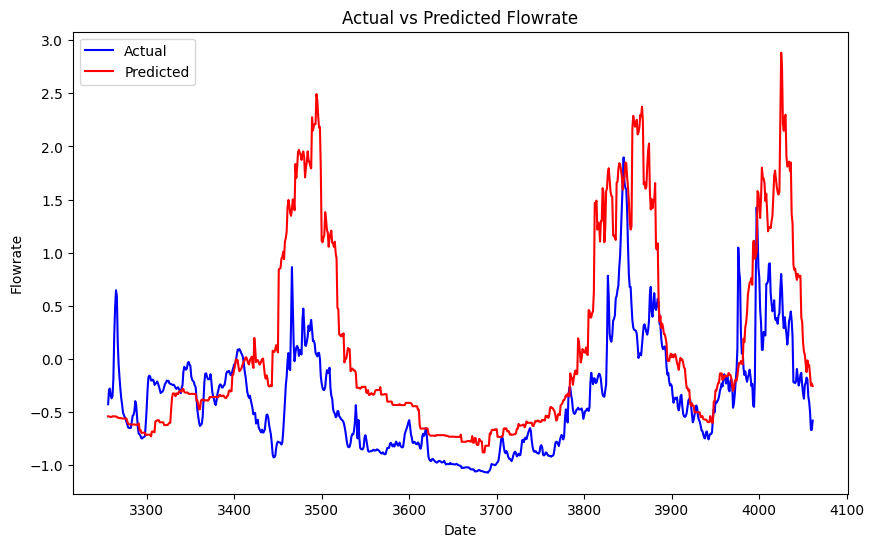

In [13]:
# Train the best model on the entire training set
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 4, 5, 6, 7, 8, 9]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the held-out test set
y_test_pred_rf = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_rf)
test_r2 = r2_score(y_test, y_test_pred_rf)

# Print test set evaluation
print("\nRandom Forest Regression Model (Test Set Evaluation)")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Print the feature importances
feature_importances = best_model.feature_importances_
features = X.columns
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances = importances.sort_values('Importance', ascending=False)
print("\nFeature Importances:")
print(importances)

# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred_rf, label='Predicted', color='red')
plt.title('Actual vs Predicted Flowrate')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

{'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

Lasso Regression Model (Test Set Evaluation)
Test MSE: 0.1669
Test R-squared: 0.3555


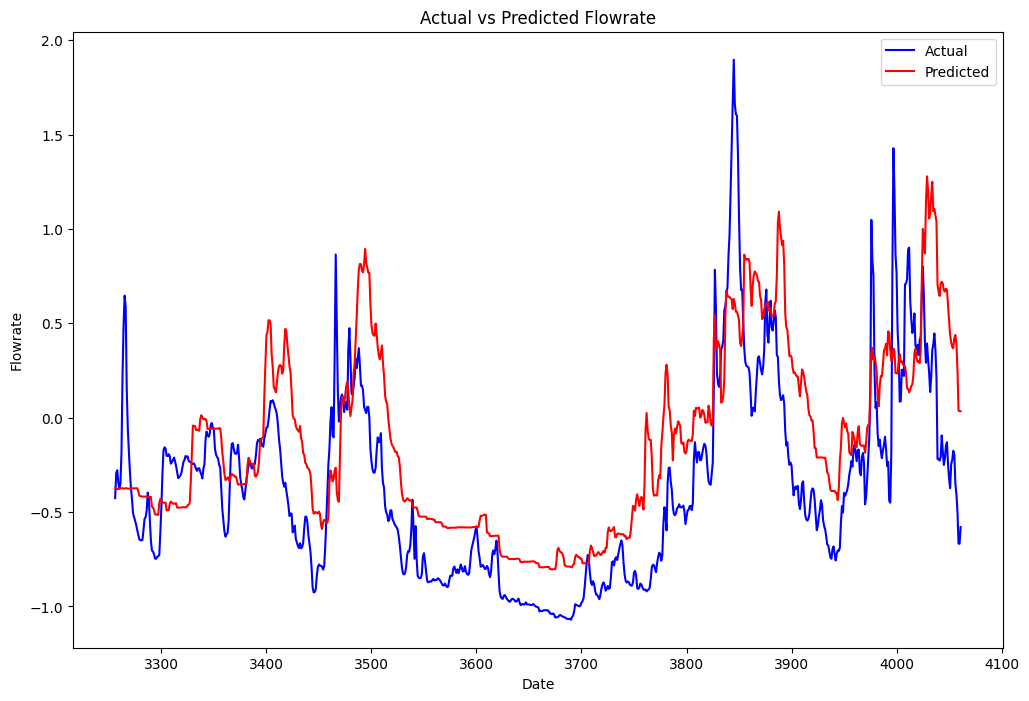

In [14]:
lasso_model = Lasso()

# Define the hyperparameter grid for Lasso
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(lasso_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_
print(best_model.get_params())

# Evaluate the best model on the held-out test set
y_test_pred_lasso = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_lasso)
test_r2 = r2_score(y_test, y_test_pred_lasso)

# Print test set evaluation
print("\nLasso Regression Model (Test Set Evaluation)")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-squared: {test_r2:.4f}")


# plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred_lasso, label='Predicted', color='red')
plt.title('Actual vs Predicted Flowrate')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 11, 'max_features': 8, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

Decision Tree Regression Model (Test Set)
Test MSE: 0.6689
Test R-squared: -1.5830

Feature Importances:
                  Feature  Importance
11      min_flow_month_ck    0.528677
1                   month    0.175169
2            week_of_year    0.139606
9      rainfall_5weeks_ck    0.077384
13                   elec    0.035549
12                   rice    0.013896
8        rainfall_week_ck    0.012605
0                    year    0.005728
10                    gdp    0.005713
3             rainfall_ck    0.001668
4        rainfall_lag1_ck    0.001553
5        rainfall_lag2_ck    0.001009
6        rainfall_lag3_ck    0.000753
7   rainfall_lag5weeks_ck    0.000690


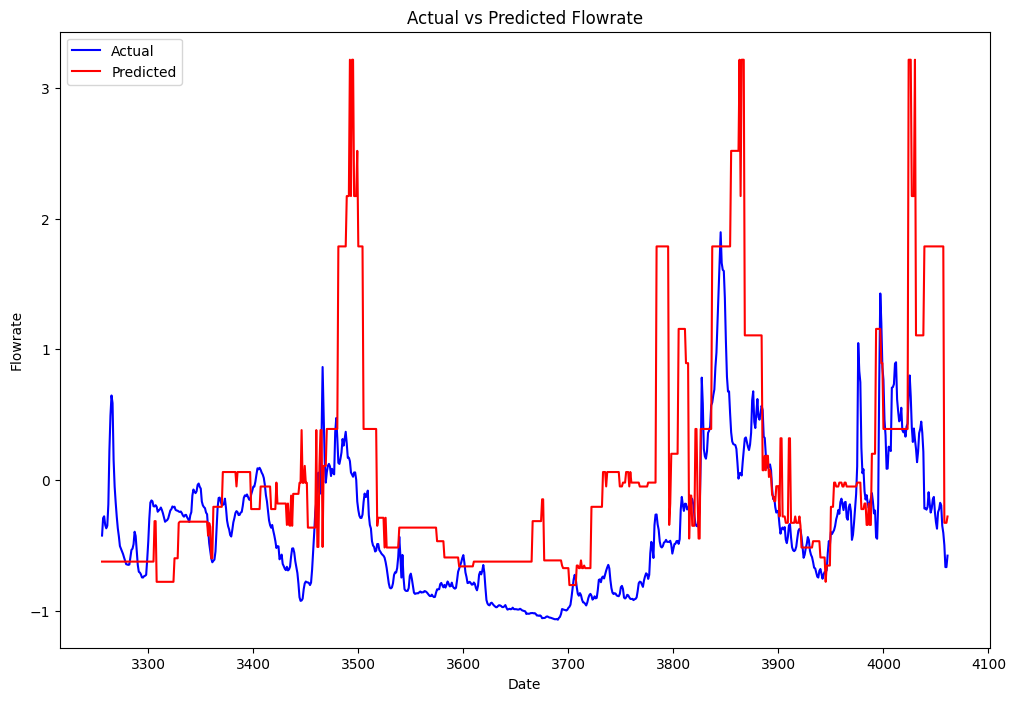

In [15]:
dt_model = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 5, 7, 9, 10, 11],
    'min_samples_split': [10, 13, 14, 15, 16, 17, 19, 21],
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'max_features': [None, 6, 7, 8, 9]
}

grid_search = GridSearchCV(dt_model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_
print(best_model.get_params())

# Evaluate the best model on the held-out test set
y_test_pred_dt = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred_dt)
test_r2 = r2_score(y_test, y_test_pred_dt)

# Print test set evaluation
print("\nDecision Tree Regression Model (Test Set)")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Print the feature importances
feature_importances = best_model.feature_importances_
features = X.columns
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances = importances.sort_values('Importance', ascending=False)
print("\nFeature Importances:")
print(importances)

# plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred_dt, label='Predicted', color='red')
plt.title('Actual vs Predicted Flowrate')
plt.xlabel('Date')
plt.ylabel('Flowrate')
plt.legend()
plt.show()